In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt  
from scipy.stats import norm
from scipy import stats
from scipy.stats import skew
from scipy.stats.stats import pearsonr

import os

In [2]:
# Load data
train = pd.read_csv('../input/tcdml1920-income-ind/tcd ml 2019-20 income prediction training (with labels).csv')
test  = pd.read_csv('../input/tcdml1920-income-ind/tcd ml 2019-20 income prediction test (without labels).csv')

# Data exploration

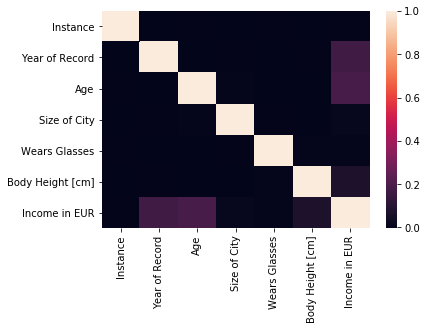

In [4]:
corrmat = train.corr()
sns.heatmap(corrmat)

In [5]:
corrmat.sort_values(["Income in EUR"], ascending = False, inplace = True)
print(corrmat['Income in EUR'])

Income in EUR       1.000000
Age                 0.186160
Year of Record      0.165116
Body Height [cm]    0.072889
Size of City        0.014993
Wears Glasses       0.005718
Instance            0.002897
Name: Income in EUR, dtype: float64


In [7]:
#This function takes a DataFrame(df) as input and returns two columns, total missing values and total missing values percentage
def missing_percentage(df):
    total = df.isnull().sum().sort_values(ascending = False)[df.isnull().sum().sort_values(ascending = False) != 0]
    percent = round(df.isnull().sum().sort_values(ascending = False) / len(df) * 100, 2)[round(df.isnull().sum().sort_values(ascending = False) / len(df) * 100, 2) != 0]
    return pd.concat([total, percent], axis = 1, keys=['Total', 'Percent'])

missing_percentage(train)

,Total,Percent
Gender,7432,6.64
University Degree,7370,6.58
Hair Color,7242,6.47
Age,494,0.44
Year of Record,441,0.39
Profession,322,0.29


In [25]:
categorical_features = train.select_dtypes(include = ["object"]).columns
numerical_features = train.select_dtypes(exclude = ["object"]).columns
numerical_features = numerical_features.drop("Income in EUR")
print("Numerical features : ")
print(numerical_features)
print("Categorical features : ")
print(categorical_features)

Numerical features : 
Index(['Instance', 'Year of Record', 'Age', 'Size of City', 'Wears Glasses',
       'Body Height [cm]'],
      dtype='object')
Categorical features : 
Index(['Gender', 'Country', 'Profession', 'University Degree', 'Hair Color'], dtype='object')


In [9]:
train['Income in EUR'].describe()

count    1.119930e+05
mean     1.092138e+05
std      1.498024e+05
min     -5.696906e+03
25%      3.077169e+04
50%      5.733917e+04
75%      1.260936e+05
max      5.285252e+06
Name: Income in EUR, dtype: float64

Negative values???

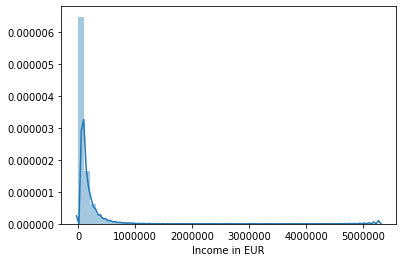

In [10]:
sns.distplot(train['Income in EUR'])

In [11]:
# Remove negative values
# NOTE: Don't do that, its part of the final sol as well
# train = train.loc[train['Income in EUR'] > 0]

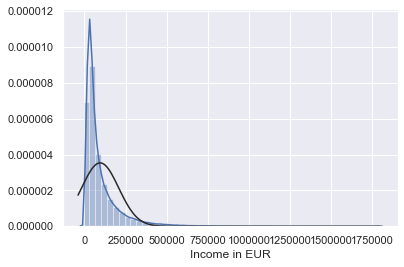

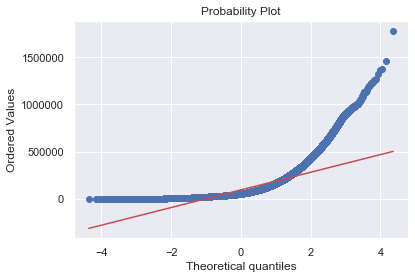

In [99]:
sns.distplot(train['Income in EUR'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['Income in EUR'], plot=plt)

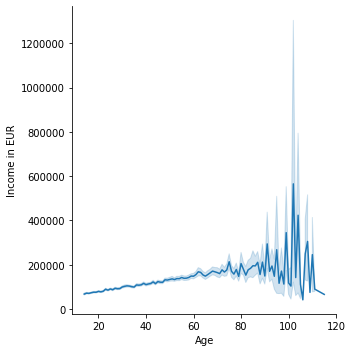

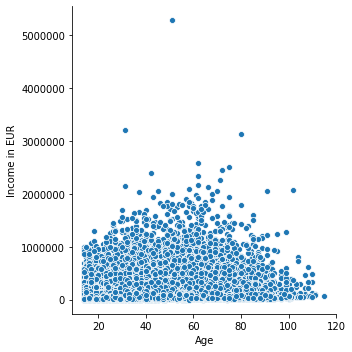

In [12]:
# plt.hist(train['Age'], bins=50)
# sns.distplot(train['Age'])
sns.relplot(x = "Age", y = "Income in EUR", data = train, kind = 'line');
sns.relplot(x = "Age", y = "Income in EUR", data = train, kind = 'scatter');

Age greater than 100 has such high incomes?

In [ ]:
# Remove age > 100
# NOTE: Again part of the data. Don't make assumptions
# train = train.loc[train['Age'] < 100]

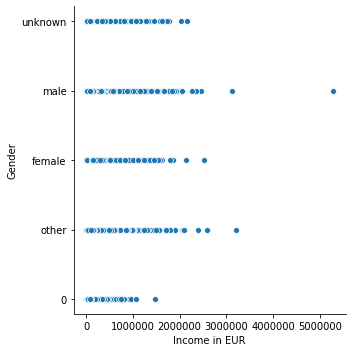

In [13]:
sns.relplot(x = "Income in EUR", y = "Gender", data = train);

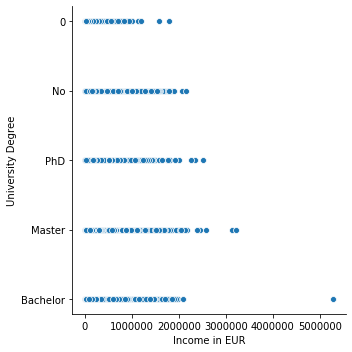

In [14]:
sns.relplot(x = "Income in EUR", y = "University Degree", data = train);

## Pair plots

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


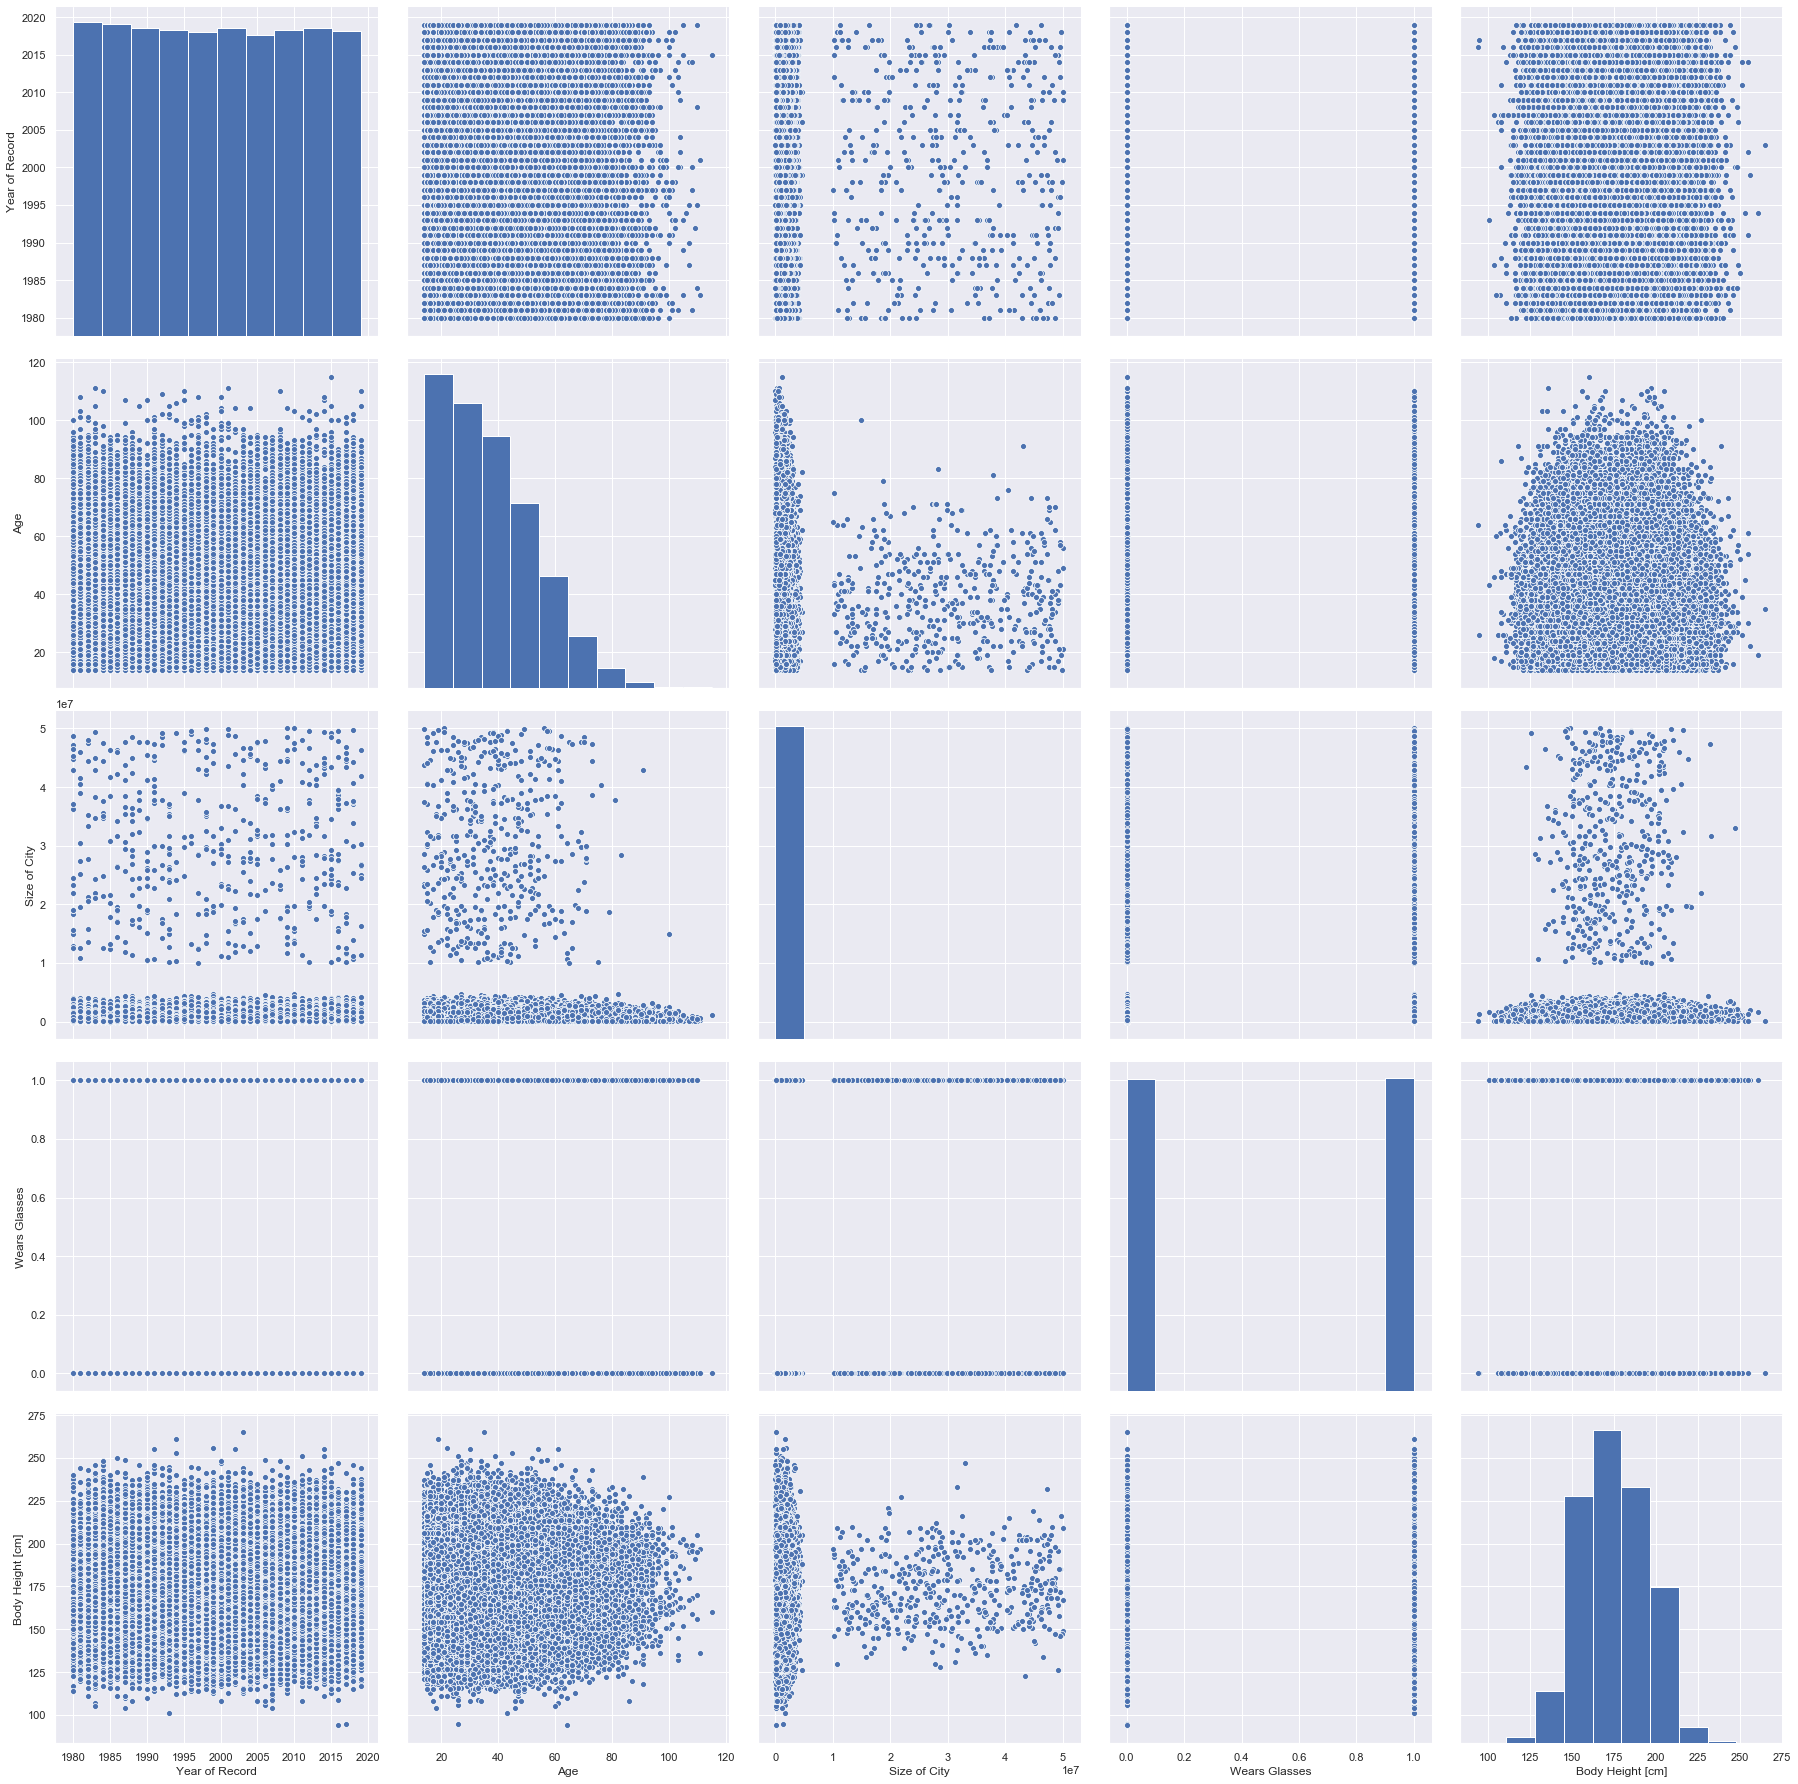

In [17]:
sns.set()
cols = ['Year of Record', 'Age', 'Size of City', 'Wears Glasses', 'Body Height [cm]']
sns.pairplot(train[cols], height = 5)
plt.show();

In [19]:
country_counts = train.groupby('Country').count()
country_counts.sort_values('Instance').head()

,Instance,Year of Record,Gender,Age,Size of City,Profession,University Degree,Wears Glasses,Hair Color,Body Height [cm],Income in EUR
Country,,,,,,,,,,,
Kiribati,1,1,1,1,1,1,1,1,1,1,1
South Africa,1,1,1,1,1,1,1,1,1,1,1
Myanmar,1,1,1,1,1,1,1,1,1,1,1
Grenada,1,1,1,1,1,1,1,1,1,1,1
Vietnam,1,1,1,1,1,1,1,1,1,1,1


A lot of countries with very few frequency

In [21]:
# Removing countries with not enough observations
# NOTE: Score did not improve with this

# invalid_countries = country_counts.loc[country_counts['Income in EUR'] < 200]
# # invalid_countries.index
# train = train.loc[~train['Country'].isin(invalid_countries.index)]
# train['Country'].describe()

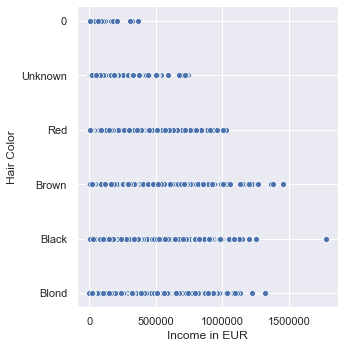

In [23]:

sns.relplot(x = 'Income in EUR', y = 'Hair Color', data = train)

# Data Transformations

In [54]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [86]:
all_data = pd.concat((train.loc[:, 'Year of Record': 'Body Height [cm]'],
                      test.loc[:, 'Year of Record': 'Body Height [cm]']))

In [87]:
categorical_features = all_data.select_dtypes(include = ["object"]).columns
numerical_features = all_data.select_dtypes(exclude = ["object"]).columns

# Rename to be able to use in models
all_data.rename(columns={ 'Body Height [cm]': 'Height' }, inplace=True)

# Replace all unknowns with NAN to fill later with median or best value count
# all_data = all_data.replace({ 'Gender': { '0' : np.nan, 'unknown': np.nan } })
# all_data = all_data.replace({ 'University Degree': { '0' : 'No', '#NaN': np.nan } })
# all_data = all_data.replace({ 'Hair Color': { '0': np.nan, 'Unknown': np.nan } })
all_data = all_data.replace({ 'Gender': { '0' : 'unknown' } })
all_data = all_data.replace({ 'University Degree': { '0' : 'No', '#NaN': np.nan } })
all_data = all_data.replace({ 'Hair Color': { '0': 'Unknown'} })

In [88]:
# Fill na's
all_data = all_data.fillna(all_data.median())

for cat in categorical_features:
    all_data[cat] = all_data[cat].fillna(all_data[cat].value_counts().index[0])

In [89]:
# Transform numerical features

# stdSc = StandardScaler()
# all_data.loc[:, numeric_feats] = stdSc.fit_transform(all_data.loc[:, numeric_feats])

scaler = MinMaxScaler()
scaler = scaler.fit(all_data[['Year of Record']])
all_data['Year of Record'] = scaler.transform(all_data[['Year of Record']]).ravel()
scaler =scaler.fit(all_data[['Age']])
all_data['Age'] = scaler.transform(all_data[['Age']]).ravel()
all_data.head()

,Year of Record,Gender,Age,Country,Size of City,Profession,University Degree,Wears Glasses,Hair Color,Height
0,0.435897,male,0.241071,Belarus,1239930,steel workers,Bachelor,0,Blond,193
1,0.410256,other,0.241071,Singapore,1603504,safe event coordinator,Master,0,Black,186
2,0.974359,other,0.125000,Norway,1298017,receivables/payables analyst,PhD,1,Brown,170
3,0.666667,other,0.169643,Cuba,751903,fleet assistant,No,1,Black,171
4,0.769231,female,0.285714,United Arab Emirates,95389,lead trainer,No,0,Blond,188


In [90]:
# Encoding categorical variables
# from category_encoders import BinaryEncoder, HashEncoder, TargetEncoder

# binary_enc = BinaryEncoder(cols=['Profession']).fit(train.loc[:, 'Year of Record':'Height'], y = train['Income in EUR'])
# all_data = ninary_enc.transform(all_data.reset_index(drop=True))

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
all_data['Profession'] = le.fit_transform(all_data['Profession'])
# all_data['Country'] = le.fit_transform(all_data['Country'])

# Dropping columns which dont seem to have any significant change
all_data.drop(columns =['Size of City', 'Wears Glasses','Hair Color', 'Height'], inplace= True)

all_data = pd.get_dummies(all_data, columns = ['University Degree', 'Gender', 'Country'])
all_data.head()

,Year of Record,Age,Profession,University Degree_Bachelor,University Degree_Master,University Degree_No,University Degree_PhD,Gender_female,Gender_male,Gender_other,...,Country_Ukraine,Country_United Arab Emirates,Country_United Kingdom,Country_Uruguay,Country_Uzbekistan,Country_Vanuatu,Country_Venezuela,Country_Yemen,Country_Zambia,Country_Zimbabwe
0,0.435897,0.241071,1220,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0.410256,0.241071,1059,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0.974359,0.125000,1019,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0.666667,0.169643,566,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0.769231,0.285714,732,0,0,1,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0


In [91]:
all_data.shape

(181986, 167)

# Train Model

In [92]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
# y = np.log1p(train['Income in EUR']).fillna(0)

In [93]:
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, train['Income in EUR'], scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [102]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(n_estimators=10, random_state=125, min_samples_split=2, n_jobs=-1)

regr.fit(X_train, train['Income in EUR'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                      oob_score=False, random_state=125, verbose=0,
                      warm_start=False)

In [103]:
rmse_cv(regr).mean()

57701.314443205505

In [105]:
prediction = regr.predict(X_test)

solution = pd.DataFrame({ 'Instance': test['Instance'], 'Income': prediction })
solution.to_csv("sol.csv", index = False)